In [1]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import UniPCMultistepScheduler
from transformers import CLIPModel, CLIPTextModel, CLIPTokenizer
from transformers import AutoModel, AutoTokenizer

text_encoder_clip = CLIPTextModel.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/text_encoder")
tokenizer_clip = CLIPTokenizer.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/tokenizer")
text_encoder_roberta = AutoModel.from_pretrained("/home/sangyeob/dev/d2d/5-K_stable_diffusion/text_encoder/robert/250000_5e-05_64")
text_encoder_roberta_raw = AutoModel.from_pretrained("klue/roberta-small")
tokenizer_roberta = AutoTokenizer.from_pretrained("klue/roberta-small")

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

torch_device = "cuda"
unet.to(torch_device)
text_encoder_clip.to(torch_device)
text_encoder_roberta.to(torch_device)
text_encoder_roberta_raw.to(torch_device)
vae.to(torch_device)
print('')

/home/sangyeob/anaconda3/envs/ksd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
n_vae = sum(p.numel() for p in vae.parameters() if p.requires_grad)
n_text_encoder_clip = sum(p.numel() for p in text_encoder_clip.parameters() if p.requires_grad)
n_text_encoder_roberta = sum(p.numel() for p in text_encoder_roberta.parameters() if p.requires_grad)
n_unet = sum(p.numel() for p in unet.parameters() if p.requires_grad)
n_total = n_vae + n_text_encoder_clip + n_text_encoder_roberta  + n_unet

n_vae = format(n_vae, ',')
n_text_encoder_clip = format(n_text_encoder_clip, ',')
n_text_encoder_roberta = format(n_text_encoder_roberta, ',')
n_unet = format(n_unet, ',')
n_total = format(n_total, ',')


print(f'text_encoder_clip : {n_text_encoder_clip}')
print(f'text_encoder_roberta : {n_text_encoder_roberta}')
print(f'vae : {n_vae}')
print(f'unet : {n_unet}')
print(f'total : {n_total}')

text_encoder_clip : 123,060,480
text_encoder_roberta : 68,090,880
vae : 83,653,863
unet : 859,520,964
total : 1,134,326,187


In [3]:
# input 준비
text = ["a dog painted by a pen", "펜으로 그린 강아지"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the inital latent noise
batch_size = len(text)

text_input_clip = tokenizer_clip(text, padding="max_length", max_length=77, truncation=True, return_tensors="pt")
text_input_roberta = tokenizer_roberta(text, padding="max_length", max_length=77, truncation=True, return_tensors="pt")
uncond_input_clip = tokenizer_clip([""] * batch_size, padding="max_length", max_length=77, return_tensors="pt")
uncond_input_roberta = tokenizer_roberta([""] * batch_size, padding="max_length", max_length=77, return_tensors="pt")

with torch.no_grad():
    x = text_embeddings_clip = text_encoder_clip(text_input_clip.input_ids.to(torch_device))
    text_embeddings_clip = text_encoder_clip(text_input_clip.input_ids.to(torch_device))[0]
    text_embeddings_roberta = text_encoder_roberta(text_input_roberta.input_ids.to(torch_device))[0]
    text_embeddings_roberta_raw = text_encoder_roberta_raw(text_input_roberta.input_ids.to(torch_device))[0]
    uncond_embeddings_clip = text_encoder_clip(uncond_input_clip.input_ids.to(torch_device))[0]
    uncond_embeddings_roberta = text_encoder_roberta(uncond_input_roberta.input_ids.to(torch_device))[0]
    uncond_embeddings_roberta_raw = text_encoder_roberta_raw(uncond_input_roberta.input_ids.to(torch_device))[0]

uncond_embeddings = torch.cat([uncond_embeddings_clip, uncond_embeddings_roberta, uncond_embeddings_roberta_raw])
text_embeddings = torch.cat([text_embeddings_clip, text_embeddings_roberta, text_embeddings_roberta_raw])
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

latents = torch.randn((batch_size * 3, unet.in_channels, height // 8, width // 8), generator=generator)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/tmp/ipykernel_487125/2325911872.py:28: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size * 3, unet.in_channels, height // 8, width // 8), generator=generator)


In [4]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):

    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    latents = scheduler.step(noise_pred, t, latents).prev_sample



100%|██████████| 25/25 [00:41<00:00,  1.67s/it]


In [5]:
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

print(type(image))
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]


<class 'torch.Tensor'>


(-0.5, 511.5, 511.5, -0.5)

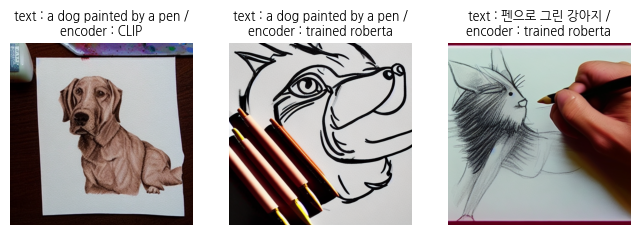

In [14]:

plt.figure(figsize=(8, 8))

plt.subplot(1, 3, 1)
plt.imshow(pil_images[0])
plt.title(f'text : {text[0]} /\nencoder : CLIP')
plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.imshow(pil_images[1])
# plt.title(f'{text[1]} / clip')
# plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(pil_images[2])
plt.title(f'text : {text[0]} /\nencoder : trained roberta')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pil_images[3])
plt.title(f'text : {text[1]} /\nencoder : trained roberta')
plt.axis('off')

In [15]:
import matplotlib.font_manager
[f.name for f in matplotlib.font_manager.fontManager.ttflist ]

['STIXSizeFourSym',
 'DejaVu Serif',
 'DejaVu Sans',
 'cmex10',
 'cmmi10',
 'DejaVu Serif',
 'NanumSquare',
 'STIXNonUnicode',
 'STIXNonUnicode',
 'DejaVu Sans',
 'STIXGeneral',
 'NanumBarunGothic',
 'STIXSizeOneSym',
 'STIXSizeFourSym',
 'STIXSizeTwoSym',
 'DejaVu Serif',
 'DejaVu Sans Display',
 'DejaVu Sans',
 'cmsy10',
 'DejaVu Sans Mono',
 'STIXSizeThreeSym',
 'NanumSquareRound',
 'DejaVu Sans Mono',
 'STIXGeneral',
 'STIXSizeOneSym',
 'NanumMyeongjo',
 'STIXSizeThreeSym',
 'STIXNonUnicode',
 'NanumBarunGothic',
 'STIXSizeTwoSym',
 'DejaVu Sans',
 'STIXSizeFiveSym',
 'DejaVu Serif Display',
 'cmss10',
 'NanumGothic',
 'cmb10',
 'DejaVu Sans Mono',
 'STIXNonUnicode',
 'DejaVu Sans Mono',
 'NanumGothic',
 'NanumSquare',
 'NanumMyeongjo',
 'STIXGeneral',
 'STIXGeneral',
 'cmr10',
 'DejaVu Serif',
 'cmtt10',
 'NanumSquareRound',
 'DejaVu Serif',
 'C059',
 'Nimbus Sans',
 'NanumMyeongjo',
 'Nimbus Sans',
 'C059',
 'DejaVu Serif',
 'D050000L',
 'DejaVu Serif',
 'Nimbus Roman',
 'DejaVu 

In [25]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic', size = 7.5)

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False